# Residential Building Classification
This is a bare-bone version of the residential vs. non-residential building classification. We use DenseNet in this implementation. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

import params
from densenet_efficient import DenseNetEfficient
from solver import *
from dataset import *
from visualize import *

# Load parameters
params = vars(params)
rbc_class_names = params['rbc_class_names']
fmow_class_names = params['fmow_class_names']
fmow_class_names_mini = params['fmow_class_names_mini']
dtype = params['dtype']

torch.set_num_threads(params['num_threads'])

## Preprocess FMOW Dataset
Check if fMoW dataset is available. If so, process the images by cropping based on given bounding boxes. Load in traing, validation and test dataset along with ground truth labels for training and validation set. 

In [2]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(8/9, 9/8)),
    transforms.ToTensor(),
])
train_set = WCDataset(params, transform=train_transforms)
print("Number of Training/Validation Images: %i" % len(train_set))
x,y = train_set[0]
print(type(x), x.shape, type(y), y.shape)

Number of Training/Validation Images: 12000
<class 'torch.IntTensor'> torch.Size([1, 224, 224]) <class 'numpy.ndarray'> (1,)


In [3]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
test_set = WCDataset(params, transform=test_transforms, train=False)
print("Number of Testing Images: %i" % len(test_set))
x,y = test_set[0]
print(type(x), x.shape, type(y), y.shape)

Number of Testing Images: 2148
<class 'torch.IntTensor'> torch.Size([1, 224, 224]) <class 'numpy.ndarray'> (1,)


### Visualize a small batch of data
Plot a small batch of training images to get a sense of data

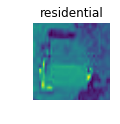

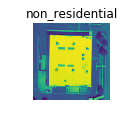

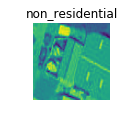

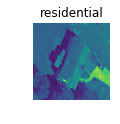

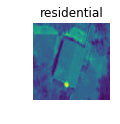

In [4]:
# Sample a minibatch and show the images and captions
size = 5
indices = np.random.choice(len(test_set), size, replace=False)

fig = plt.figure()

for i, idx in enumerate(indices):
    image, label = test_set[idx]
    plt.subplot(1, size, i + 1)
    plt.title(params['rbc_class_names'][label[0]])
    plt.axis('off')
    plt.imshow(image[0,:,:])
    plt.gcf().set_size_inches(8, 8)
    plt.show()

## Load Model
Load in DenseNet. Configure training parameters. 

In [5]:
model = DenseNetEfficient(
        growth_rate=32, 
        block_config=(6, 12, 24, 16), 
        compression=0.5,
        num_init_features=64, 
        bn_size=4, 
        drop_rate=0,
        num_classes=20, 
        small_inputs=False)
# Move model to GPU
model = model.cuda()
# print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Parameters: %i" % pytorch_total_params)

Total Parameters: 6968084


/home/feng/anaconda3/envs/rbc_env/lib/python3.6/site-packages/torch/nn/modules/container.py:13: UserWarning: nn.Container is deprecated. All of it's functionality is now implemented in nn.Module. Subclass that instead.
  warnings.warn("nn.Container is deprecated. All of it's functionality "


In [6]:
# Modify the model to predict 2 categories
model.classifier = nn.Sequential(
              nn.Linear(1024, 128),
              nn.ReLU(),
              nn.Linear(128, 2))

In [7]:
# Load an existing model trained on 20 categories
model.load_state_dict(torch.load('/home/feng/ext2/feng/workspace/residential_building_challenge/output/cat_2_fmow_50000_wake_10000/model.dat'))

## Train Model
Train the model one epoch at a time. Keep the verbose option on to monitor the loss during training. 
Save training and validation accuracy history for visualization. 

In [ ]:
train(model, 
      train_set, 
      None, 
      '/home/feng/ext2/feng/workspace/residential_building_challenge/output', 
      n_epochs=20, 
      valid_size=1000,
      batch_size=50, 
      lr=0.01, 
      wd=0.0001, 
      momentum=0.9, 
      seed=None)

Epoch: [1/20]	Iter: [1/220]	Time 0.825 (0.825)	Loss 0.6261 (0.6261)	Error 0.1600 (0.1600)
Epoch: [1/20]	Iter: [2/220]	Time 0.736 (0.780)	Loss 0.8339 (0.7300)	Error 0.2000 (0.1800)
Epoch: [1/20]	Iter: [3/220]	Time 0.731 (0.764)	Loss 0.7591 (0.7397)	Error 0.1400 (0.1667)
Epoch: [1/20]	Iter: [4/220]	Time 0.715 (0.752)	Loss 0.2582 (0.6193)	Error 0.0800 (0.1450)
Epoch: [1/20]	Iter: [5/220]	Time 0.696 (0.741)	Loss 0.4166 (0.5788)	Error 0.1000 (0.1360)
Epoch: [1/20]	Iter: [6/220]	Time 0.695 (0.733)	Loss 0.6002 (0.5824)	Error 0.2400 (0.1533)
Epoch: [1/20]	Iter: [7/220]	Time 0.698 (0.728)	Loss 0.2669 (0.5373)	Error 0.0800 (0.1429)
Epoch: [1/20]	Iter: [8/220]	Time 0.695 (0.724)	Loss 0.5122 (0.5342)	Error 0.1600 (0.1450)
Epoch: [1/20]	Iter: [9/220]	Time 0.698 (0.721)	Loss 0.1718 (0.4939)	Error 0.0800 (0.1378)
Epoch: [1/20]	Iter: [10/220]	Time 0.730 (0.722)	Loss 0.5471 (0.4992)	Error 0.2200 (0.1460)
Epoch: [1/20]	Iter: [11/220]	Time 0.728 (0.722)	Loss 0.2723 (0.4786)	Error 0.1000 (0.1418)
Epoch: [

## Visualization
Visualize training and validation accuracy throughout training history. 
Visualize loss function. 

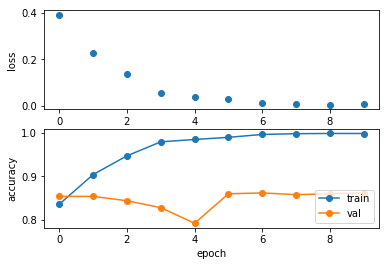

In [9]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

with open(os.path.join('/home/feng/ext2/feng/workspace/residential_building_challenge/output', 'results.csv'), 'r') as f:
        for line in f:
            numbers = line.split(',')
            if(numbers[0]=='epoch'):
                continue
            try:
                train_loss.append(float(numbers[1]))
                train_acc.append(1-float(numbers[2]))
                valid_loss.append(float(numbers[3]))
                valid_acc.append(1-float(numbers[4]))
            except ValueError:
                continue


# Visualize loss history and training/validation accuracy history
plt.subplot(2, 1, 1)
plt.plot(train_loss, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc, '-o')
plt.plot(valid_acc, '-o')
plt.legend(['train', 'val'], loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Test Model
Make predictions based on test dataset. Visually assess the quality of prediction and compute accuracy based on groundtruth. 

In [14]:
# Check accuracy of model on Test set
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False,
                                              pin_memory=(torch.cuda.is_available()), num_workers=0)
test_epoch(model, test_loader)

Test	Iter: [1/135]	Time 0.173 (0.173)	Loss 1.2558 (1.2558)	Error 0.3125 (0.3125)
Test	Iter: [2/135]	Time 0.125 (0.149)	Loss 1.1078 (1.1818)	Error 0.1875 (0.2500)
Test	Iter: [3/135]	Time 0.111 (0.137)	Loss 0.3417 (0.9018)	Error 0.1250 (0.2083)
Test	Iter: [4/135]	Time 0.107 (0.129)	Loss 1.0755 (0.9452)	Error 0.1875 (0.2031)
Test	Iter: [5/135]	Time 0.108 (0.125)	Loss 1.0355 (0.9633)	Error 0.2500 (0.2125)
Test	Iter: [6/135]	Time 0.108 (0.122)	Loss 0.6721 (0.9147)	Error 0.2500 (0.2188)
Test	Iter: [7/135]	Time 0.107 (0.120)	Loss 0.7067 (0.8850)	Error 0.1250 (0.2054)
Test	Iter: [8/135]	Time 0.109 (0.119)	Loss 0.7208 (0.8645)	Error 0.2500 (0.2109)
Test	Iter: [9/135]	Time 0.107 (0.117)	Loss 1.7197 (0.9595)	Error 0.5000 (0.2431)
Test	Iter: [10/135]	Time 0.104 (0.116)	Loss 0.8636 (0.9499)	Error 0.1250 (0.2313)
Test	Iter: [11/135]	Time 0.098 (0.114)	Loss 1.7021 (1.0183)	Error 0.3750 (0.2443)
Test	Iter: [12/135]	Time 0.097 (0.113)	Loss 0.2487 (0.9542)	Error 0.0625 (0.2292)
Test	Iter: [13/135]	Time 

Test	Iter: [104/135]	Time 0.099 (0.100)	Loss 0.8454 (0.9945)	Error 0.1250 (0.2368)
Test	Iter: [105/135]	Time 0.097 (0.100)	Loss 1.6007 (1.0003)	Error 0.2500 (0.2369)
Test	Iter: [106/135]	Time 0.097 (0.100)	Loss 0.7136 (0.9976)	Error 0.3125 (0.2376)
Test	Iter: [107/135]	Time 0.099 (0.100)	Loss 0.8701 (0.9964)	Error 0.2500 (0.2377)
Test	Iter: [108/135]	Time 0.097 (0.100)	Loss 1.0432 (0.9968)	Error 0.2500 (0.2378)
Test	Iter: [109/135]	Time 0.097 (0.099)	Loss 0.9899 (0.9968)	Error 0.1875 (0.2374)
Test	Iter: [110/135]	Time 0.100 (0.099)	Loss 0.9936 (0.9967)	Error 0.3125 (0.2381)
Test	Iter: [111/135]	Time 0.096 (0.099)	Loss 1.9003 (1.0049)	Error 0.4375 (0.2399)
Test	Iter: [112/135]	Time 0.099 (0.099)	Loss 0.9769 (1.0046)	Error 0.3125 (0.2405)
Test	Iter: [113/135]	Time 0.099 (0.099)	Loss 1.1064 (1.0055)	Error 0.2500 (0.2406)
Test	Iter: [114/135]	Time 0.099 (0.099)	Loss 0.6933 (1.0028)	Error 0.1250 (0.2396)
Test	Iter: [115/135]	Time 0.097 (0.099)	Loss 0.7243 (1.0004)	Error 0.1875 (0.2391)
Test

(0.09870709136680321, 1.0113925540913418, 0.24022346368715083)

## Visualize Saliency Map

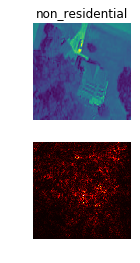

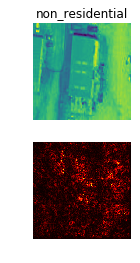

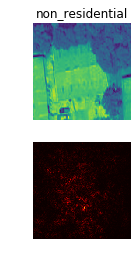

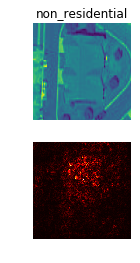

In [13]:
for batch_idx, (input, target) in enumerate(test_loader):
    target = target[:,0]
    input = input.type(torch.FloatTensor)

    saliency_maps = compute_saliency_maps(input, target, model)
    saliency_maps = saliency_maps.cpu().numpy()
    
    indices = [1, 2, 3, 4]
    fig = plt.figure()
    N = len(indices)
    for i, idx in enumerate(indices):
        plt.subplot(2, N, i + 1)
        plt.imshow(input.numpy()[idx,0,:,:])
        plt.axis('off')
        plt.title(rbc_class_names[target.numpy()[0]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency_maps[idx,0,:,:], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(8, 4)
        plt.show()
    
    break



In [12]:
# Sample a minibatch and show the images and captions
size = 5
indices = [1,2,3,4,5]
saliency_X, saliency_y = test_set[1,:,:,:]
saliency_maps = compute_saliency_maps(saliency_X, saliency_y, model)
saliency_maps = saliency_maps.numpy()

fig = plt.figure()
N = len(indices)
for i in range(N):
    plt.subplot(2, N, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(rbc_class_names[saliency_y[i]])
    plt.subplot(2, N, N + i + 1)
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 5)
    plt.show()
 

TypeError: unhashable type: 'slice'

## Class Visualization

In [ ]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Scale(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

In [ ]:
def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and also wrap it in
    # a PyTorch Variable.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype)
    img_var = Variable(img, requires_grad=True)

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.copy_(jitter(img, ox, oy))

        ########################################################################
        # TODO: Use the model to compute the gradient of the score for the     #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        pass
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        
        # Undo the random jitter
        img.copy_(jitter(img, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.cpu())

### Visualize Successful and Failed Examples

In [ ]:
X_success = np.array([]).reshape((0, 1, 200, 200))
y_success = np.array([]).reshape((0,))
X_failure = np.array([]).reshape((0, 1, 200, 200))
y_failure = np.array([]).reshape((0,))

model.eval() 
for X, y in loader_test:
    X_var = Variable(X.type(dtype), volatile=True)
    scores = model(X_var)
    _, preds = scores.data.cpu().max(1)
    idx_success = (preds == y).numpy() == 1
    idx_failure = (preds != y).numpy() == 1
    X = X.numpy()
    y = y.numpy()
    X_success = np.append(X_success, X[idx_success.tolist(), :, :, :], axis=0)
    y_success = np.append(y_success, y[idx_success.tolist(), ], axis=0)
    X_failure = np.append(X_failure, X[idx_failure.tolist(), :, :, :], axis=0)
    y_failure = np.append(y_failure, preds[idx_failure.tolist(), ], axis=0)
    
y_success = y_success.astype(np.int32)
y_failure = y_failure.astype(np.int32)

In [ ]:
# Sample a batch of successfully classified images
for i in range(12):
    plt.subplot(3, 4, i+1)
    img = np.moveaxis(X_success[i, :, :, :], 0, -1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title(rbc_class_names[y_success[i]])
    plt.show()

In [ ]:
# Sample a batch of incorrectly classified images
plt.title('Failure Examples')
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = np.moveaxis(X_failure[i, :, :, :], 0, -1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title(rbc_class_names[y_failure[i]])
    plt.show()